In [412]:
import os
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [413]:
# 以每个点到其他所有点的平均值作为每个数据点的平均邻域半径
def compute_avg_radius(Data, distances): 
    n = Data.shape[0] # 数据集的大小
    radius = np.zeros(n) # 存储每个数据点的平均邻域半径
    for i in range(n): # 计算每个数据点的平均邻域半径
        avg_radius = np.mean(distances[i]) # 每个数据点到其他所有点的平均值
        radius[i] = avg_radius # 存储每个数据点的平均邻域半径
    return radius

In [414]:
Pi = 3.14159265358979323846

def knn_graph(Data, method, k):
    """
    计算k近邻图

    Args:
    - Data: 输入数据集的矩阵，每行代表一个样本点
    - k: 最近邻的数量

    Returns:
    - knn_graph: k近邻图的邻接矩阵，W[i, j]表示样本点i和j之间是否相连
    """
    # 获取样本点的数量
    n = Data.shape[0]
    # 初始化k近邻图的邻接矩阵
    knn_graph = np.zeros((n, n))  
    # 计算欧式距离矩阵
    distances = np.sqrt(np.sum((Data[:, None] - Data) ** 2, axis=2))
    if method == 'epsilon':
        return knn_graph, distances
    # 获取每个样本点的最近邻索引
    indices = np.argsort(distances, axis=1)[:, 1:k+1]
    # 构建k近邻图的权重矩阵
    # 遍历每个样本点的最近邻索引
    for i in range(n):
        # 将样本点i与其最近邻之间的权重设置为1
        for j in indices[i]:
            knn_graph[i, j] = 1
            knn_graph[j, i] = 1  # 由于是无向图，因此也需要设置对称位置的权重为1
    return knn_graph, distances


# 计算k最近邻索引矩阵或epsilon邻接矩阵
def compute_neighborhood_matrix(Data, method, k):
    n = len(Data)
    knn_adjacency_matrix, distances = knn_graph(Data, method, k)
    if method == 'knn':
        np.savetxt('knn_adjacency_matrix.csv', knn_adjacency_matrix, delimiter = ',')
        return knn_adjacency_matrix, distances
    elif method == 'epsilon':
        adjacency_matrix= np.zeros((n, n))
        radius = compute_avg_radius(Data, distances)  # 计算每个数据点的邻域半径
        for i in range(n):  # 对于数据集中的每个样本点 i
            neighbors = np.where(distances[i] <= radius[i])[0]  # 选择半径内的点作为邻居
            if len(neighbors) > n/2:  # 如果邻居数量超过 n/2
                sorted_indices = np.argsort(distances[i, neighbors])  # 根据距离排序邻居点的索引
                selected_neighbors = neighbors[sorted_indices[:int(n/2)]]  # 仅选择最近的 n/2 个点作为邻居
                adjacency_matrix[i, selected_neighbors] = 1 # 更新邻接矩阵
                adjacency_matrix[selected_neighbors, i] = 1 # 邻接矩阵为对称矩阵
            else:
                adjacency_matrix[i, neighbors] = 1
                adjacency_matrix[neighbors, i] = 1
        return adjacency_matrix, distances

# 构建基于热核方法的权重矩阵
def construct_weight_matrix(Data, method, n_neighbors, t):
    n = len(Data)
    Weight_matrix = np.zeros((n, n))
    adjacency_matrix, distances = compute_neighborhood_matrix(Data, method, n_neighbors)
    if method == 'knn':
        for i in range(n):
            # 获取与样本点i相连的样本点索引
            connected_indices = np.where(adjacency_matrix[i] == 1)[0]
            # 计算样本点i与相连样本点之间的相似度
            for j in connected_indices:
                # 使用高斯核函数计算相似度
                Weight_matrix[i, j] = np.exp(-1 * distances[i, j] ** 2 / t)
                Weight_matrix[j, i] = Weight_matrix[i, j]  # 对称矩阵
    elif method == 'epsilon':
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if adjacency_matrix[i, j] == 1:  # 如果样本点 j 在第i个样本点的epsilon邻域内
                    distance = np.linalg.norm(Data[i] - Data[j])  # 计算样本点 i 和 j 之间的距离（欧式距离）
                    Weight_matrix[i, j] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 使用热核方法计算权重
                    Weight_matrix[j, i] = np.exp(-distance ** 2 / (4 * t)) * 1 / ((4 * Pi * t) ** (1 / 2))  # 邻接矩阵为对称矩阵
    # 计算全局相似度
    '''
    修正权重矩阵的原理是利用全局相似度来修正局部相似度得到的权重矩阵，以使得整个权重矩阵更加平滑和连续。
    '''
    global_similarity = np.exp(-distances ** 2 / t)
    # 使用全局相似度修正权重矩阵
    Weight_matrix += global_similarity
    return Weight_matrix                


In [415]:
# 进行特征映射
def eigen_mapping(Laplacian_matrix, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = eigh(Laplacian_matrix)
    # 将特征向量按照特征值从小到大排序
    sorted_indices = np.argsort(eigenvalues)
    # 选择最小的 n_components 个特征向量
    selected_indices = sorted_indices[:n_components + 1]
    # 丢弃最小的特征向量
    selected_indices = selected_indices[1:]
    # 返回特征向量
    selected_eigenvectors = eigenvectors[:, selected_indices]
    return selected_eigenvectors

In [416]:
# LPP 算法
def LPP(Data, d, method, n_neighbors, t):
    # Step 1: 构建基于权重矩阵
    Weight_matrix = construct_weight_matrix(Data, method, n_neighbors, t)
    np.savetxt('Weight_matrix.csv', Weight_matrix, delimiter=',')
    # Step 2: 计算度矩阵和拉普拉斯矩阵
    Degree_matrix = np.diag(np.sum(Weight_matrix, axis=1))
    Laplacian_matrix = Degree_matrix - Weight_matrix
    # Step 3: 进行特征映射
    selected_eigenvectors = eigen_mapping(Laplacian_matrix, d)
    return selected_eigenvectors

In [417]:
# 示例数据
Data = np.load('./swiss roll-1000.npy')
np.savetxt('Data.csv', Data, delimiter = ',')
# 将 X 格式化为 (n_samples, n_features)
Data_T = np.transpose(Data)
np.savetxt('Data_T.csv', Data_T, delimiter = ',')

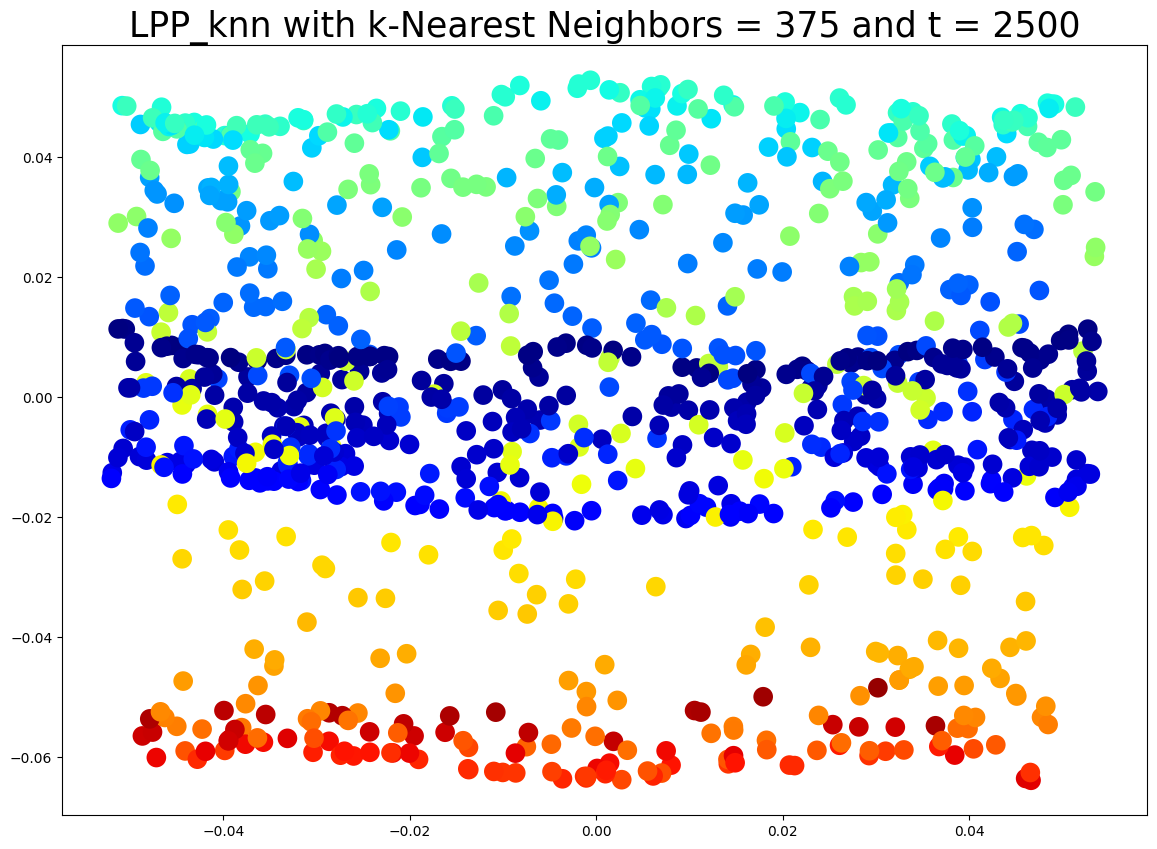

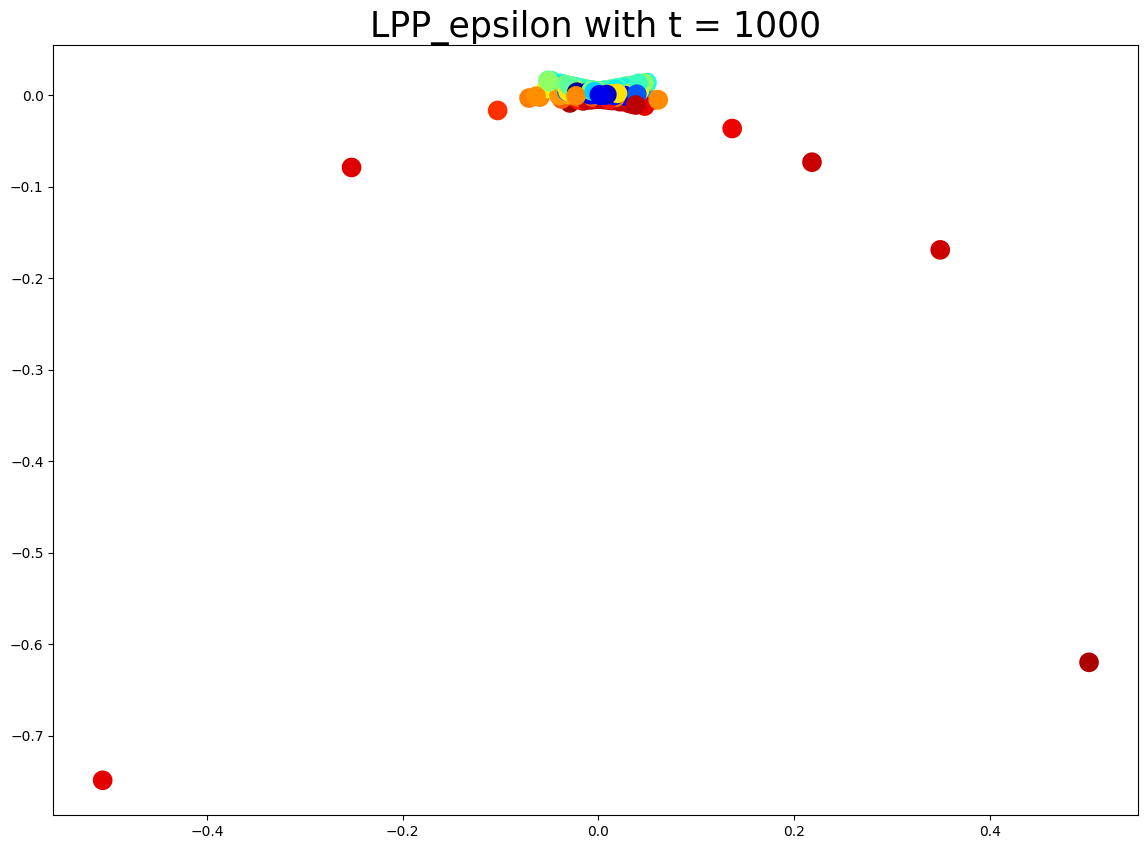

In [418]:
# 绘制及保存投影图
if not os.path.exists('output'):
    os.makedirs('output')
for method in ['knn', 'epsilon']:
    plt.figure(figsize=(14, 10))
    if method == 'epsilon':
        t= 1000
        n_neighbors = 300
        lpp_embeddings = LPP(Data_T, d=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP_epsilon with t = ' + str(t), size=25)
        file_name = 'LPP_epsilon_t = ' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    elif method == 'knn':
        n_neighbors = 375
        t= 2500
        lpp_embeddings = LPP(Data_T, d=2, method=method, n_neighbors=n_neighbors, t=t)
        plt.title('LPP_knn with k-Nearest Neighbors = ' + str(n_neighbors) + ' and t = ' + str(t), size=25)
        file_name = 'LPP_knn_' + str(n_neighbors) + '_t=' + str(t) + '.png'
        file_path = os.path.join('.', 'output', file_name)
        plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
        plt.savefig(file_path)
    plt.show()


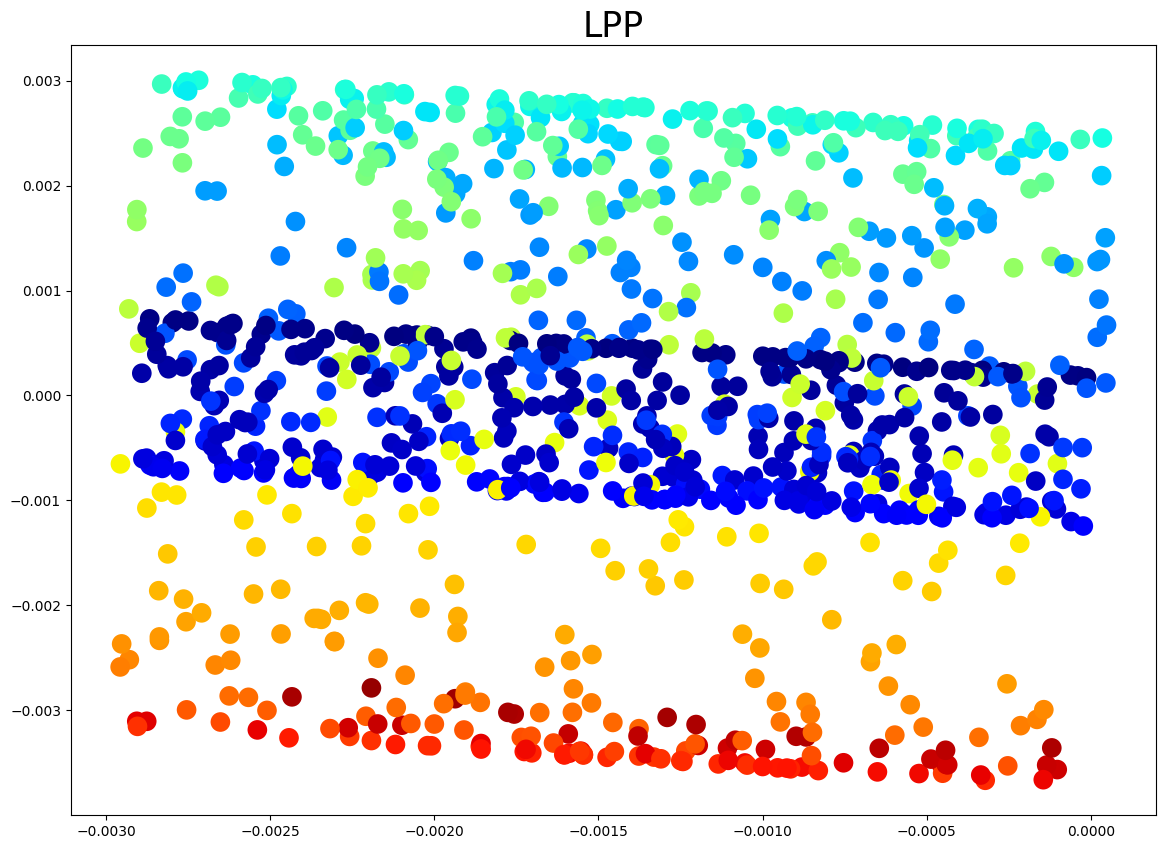

In [419]:
from lpproj import LocalityPreservingProjection
#创建 LPP 模型
lpp = LocalityPreservingProjection(n_neighbors=n_neighbors, n_components= 2)
# 使用 LPP 模型拟合瑞士卷数据集
lpp.fit(Data_T)
# 将数据集进行降维处理
y = lpp.transform(Data_T)
# 绘制及保存投影图
plt.figure(figsize=(14, 10))
plt.title('LPP', size=25)
plt.scatter(y[:, 0], y[:, 1], c=plt.cm.jet((Data_T[:, 0] ** 2 + Data_T[:, 2] ** 2) / 100),s=200, lw=0, alpha=1)
plt.show()


In [420]:
def compute_error(original_matrix, reduced_matrix):
    """
    计算两个矩阵的误差
    Args:
    - original_matrix: 原始数据集的矩阵
    - reduced_matrix: 降维后数据集的矩阵
    Returns:
    - error: 误差
    """
    # 计算欧式距离矩阵
    distance_matrix = np.sqrt(np.sum((original_matrix[:, None] - reduced_matrix) ** 2, axis=2))
    
    # 计算误差，取距离矩阵的平均值
    error = np.mean(distance_matrix)
    
    return error

# 示例用法
# error = compute_error(original_matrix, reduced_matrix)


In [421]:
compute_error(y, lpp_embeddings)

0.01452111717326706